In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
import statsmodels.api as sm


In [3]:
def plot(data):
    data = data.copy()
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True, sharex=True)
    data["date"] = pd.to_datetime(data["date"])

    axs[0].plot(data["date"], data["gdp"], label="GDP", color="b")
    axs[0].set_title("GDP")
    axs[0].grid()

    axs[1].plot(data["date"], data["cpi"], label="CPI", color="g")
    axs[1].set_title("CPI")
    axs[1].grid()

    axs[2].plot(data["date"], data["ir"], label="Interest Rate", color="r")
    axs[2].set_title("Interest Rate")
    axs[2].grid()

    axs[2].xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year
    axs[2].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # Minor ticks every quarter

    axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for label in axs[2].get_xticklabels():
        if int(label.get_text()) % 5 != 0:  # Hide labels that are not multiples of 5
            label.set_visible(False)

    plt.xticks(rotation=30)
    plt.show()

def plot_growth(data):
    data = data.copy()
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True, sharex=True)
    data["date"] = pd.to_datetime(data["date"])

    axs[0].plot(data["date"], data["gdp_growth"], label="GDP Growth", color="b")
    axs[0].set_title("GDP")
    axs[0].grid()

    axs[1].plot(data["date"], data["cpi_growth"], label="CPI Growth", color="g")
    axs[1].set_title("CPI")
    axs[1].grid()

    plt.xticks(rotation=30)
    plt.show()

def prepare_AR_data(data, variable, p, p_max, intercept=True):
    y = data[variable].iloc[p_max:].reset_index(drop=True)
    X = pd.DataFrame()
    if intercept:
        X['intercept'] = np.ones(len(y))
    # Add lagged variables for all lags from 1 to p, but taking p_max into account to make sure we can properly compare the models
    for lag in range(1, p + 1):
        X[f'lag_{lag}'] = data[variable].shift(lag).iloc[p_max:].reset_index(drop=True)
    return X, y

def estimate_AR_model(y,X):
    y_array = np.array(y)
    X_array = np.array(X)
    beta_hat = np.linalg.inv(X_array.T @ X_array) @ X_array.T @ y_array
    residuals = y_array - X_array @ beta_hat
    n = len(y)
    k = X_array.shape[1]
    sigma_hat = residuals.T@residuals / (n - k)
    se_beta = np.sqrt(np.diagonal(sigma_hat * np.linalg.inv(X_array.T @ X_array)))
    t_stats = beta_hat / se_beta
    return beta_hat, residuals, se_beta, t_stats

def calculate_AIC_loglik(residuals, p, N):
    dsigma_hat = np.sum(residuals**2) / (N - p) #this is the one needed for the AIC, based on full sample N
    dsigmalogdet = np.log(dsigma_hat)
    dloglik = -0.5 * (dsigmalogdet + (N - p) * (1 + np.log(2 * np.pi)))
    daic = dsigmalogdet + (2.0 * p / N)
    return dloglik, daic, dsigma_hat

def run_AR_models(data, variable, max_lags, intercept):
    for lag_p in range(1, max_lags + 1):
        X, y = prepare_AR_data(data, variable, lag_p, max_lags, intercept)
        beta_hat, residuals, se_beta, t_stats = estimate_AR_model(y, X)
        N = len(data)
        dloglik, daic, dsigma_hat = calculate_AIC_loglik(residuals, lag_p, N)
        results_df = pd.DataFrame({
            'lag': [lag_p] * (lag_p + 1),
            'variable': ['const'] + [f'{variable}_{i}' for i in range(1, lag_p + 1)],
            'coef': [beta_hat[0]] + list(beta_hat[1:]),
            'se': [se_beta[0]] + list(se_beta[1:]),
            't-value': [t_stats[0]] + list(t_stats[1:])
        })
        print(results_df)
        print("Log-likelihood: %.4f"%dloglik)
        print("AIC: \t\t%.4f"%daic)

In [4]:
file_path = "data/data_assignment2.csv"
data = pd.read_csv(file_path)
total_quarters = len(data)
years_short = 5                                     # 5 years since covid started
quarters_short = total_quarters - years_short * 4 -1# Each year has 4 quarters

data['gdp_growth'] = 100 * np.diff(np.log(data['gdp']), prepend=np.nan)
data['cpi_growth']= 100 * np.diff(np.log(data['cpi']), prepend=np.nan)
data = data.iloc[1:].reset_index(drop=True)
# Loose one observation due to differencing, however the new dataset has columns with dl values so these can also
# be used, and one observation is not lost
print(data)

     Unnamed: 0        date        gdp         cpi        ir     DLgdp  \
0             2  1954-10-01    399.734   26.756667  0.986667  0.022102   
1             3  1955-01-01    413.073   26.793333  1.343333  0.032825   
2             4  1955-04-01    421.532   26.756667  1.500000  0.020271   
3             5  1955-07-01    430.221   26.776667  1.940000  0.020403   
4             6  1955-10-01    437.092   26.856667  2.356667  0.015845   
..          ...         ...        ...         ...       ...       ...   
275         277  2023-07-01  27967.697  306.034333  5.260000  0.018545   
276         278  2023-10-01  28296.967  308.099000  5.330000  0.011704   
277         279  2024-01-01  28624.069  310.989667  5.330000  0.011493   
278         280  2024-04-01  29016.714  313.160333  5.330000  0.013624   
279         281  2024-07-01  29374.914  314.113667  5.263333  0.012269   

        DLcpi  gdp_growth  cpi_growth  
0   -0.003110    2.210200   -0.310965  
1    0.001369    3.282501    0.

## Data including COVID

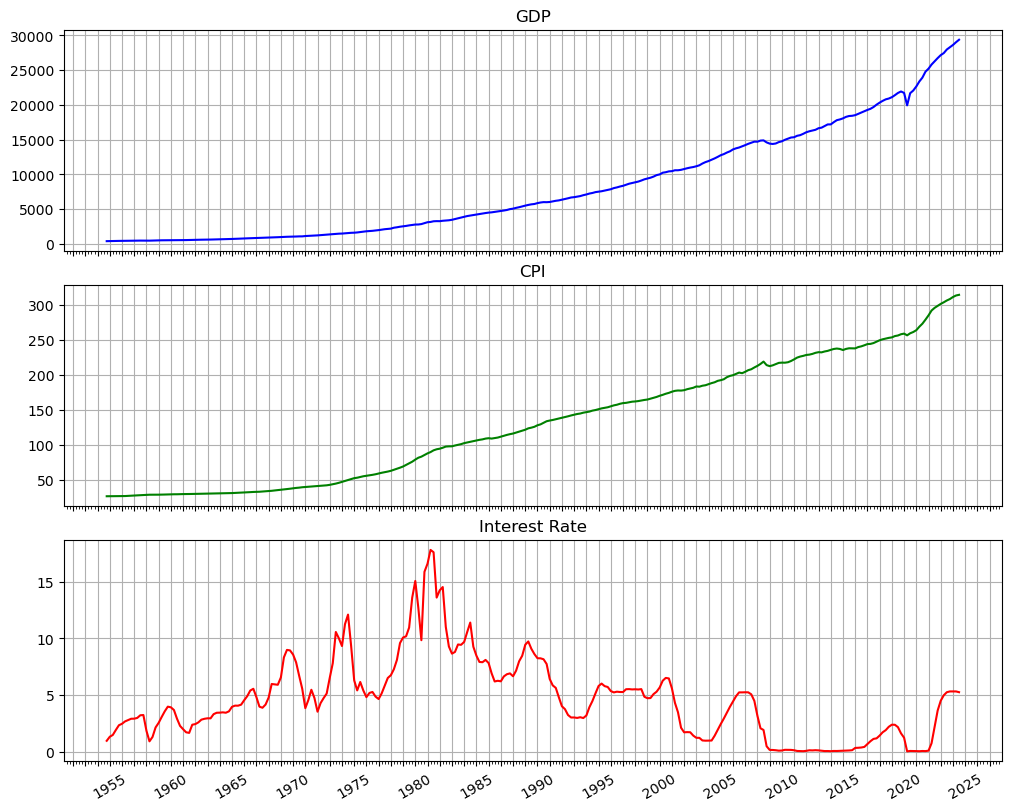

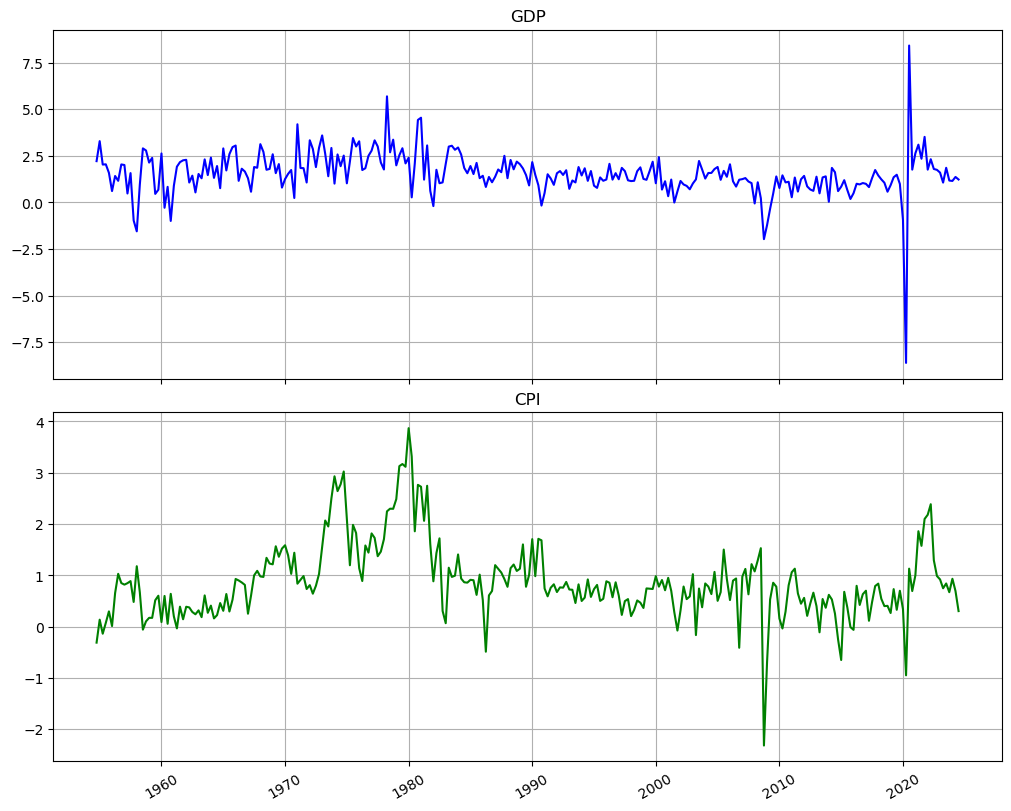

In [15]:
plot(data)
plot_growth(data)

In [7]:
max_lags=5
intercept = True
run_AR_models(data, 'gdp', max_lags, intercept)

   lag variable      coef         se     t-value
0    1    const  8.751315  15.741042    0.555955
1    1    gdp_1  1.011770   0.001408  718.715918
Log-likelihood: -401.0522
AIC: 		10.3439
   lag variable      coef         se    t-value
0    2    const  9.152216  15.704144   0.582790
1    2    gdp_1  0.919046   0.060373  15.222899
2    2    gdp_2  0.093865   0.061099   1.536277
Log-likelihood: -399.6308
AIC: 		10.3460
   lag variable      coef         se    t-value
0    3    const  8.809516  15.704660   0.560949
1    3    gdp_1  0.924946   0.060623  15.257321
2    3    gdp_2  0.151467   0.082148   1.843828
3    3    gdp_3 -0.064350   0.061357  -1.048764
Log-likelihood: -398.2116
AIC: 		10.3527
   lag variable      coef         se    t-value
0    4    const  8.450870  15.689332   0.538638
1    4    gdp_1  0.920037   0.060677  15.162862
2    4    gdp_2  0.163130   0.082565   1.975765
3    4    gdp_3  0.006034   0.082576   0.073074
4    4    gdp_4 -0.078107   0.061414  -1.271822
Log-likeli

In [8]:
run_AR_models(data, 'cpi', max_lags, intercept)

   lag variable      coef        se      t-value
0    1    const  0.316019  0.113154     2.792826
1    1    cpi_1  1.005504  0.000722  1392.214189
Log-likelihood: -395.8768
AIC: 		-0.0070
   lag variable      coef        se    t-value
0    2    const  0.164491  0.096982   1.696100
1    2    cpi_1  1.539993  0.051384  29.970296
2    2    cpi_2 -0.537574  0.051677 -10.402601
Log-likelihood: -394.2922
AIC: 		-0.3312
   lag variable      coef        se    t-value
0    3    const  0.152447  0.096920   1.572922
1    3    cpi_1  1.485311  0.060630  24.498093
2    3    cpi_2 -0.380472  0.106523  -3.571740
3    3    cpi_3 -0.102702  0.060957  -1.684834
Log-likelihood: -392.8698
AIC: 		-0.3309
   lag variable      coef        se    t-value
0    4    const  0.134377  0.095898   1.401240
1    4    cpi_1  1.467049  0.060204  24.368081
2    4    cpi_2 -0.443810  0.107515  -4.127879
3    4    cpi_3  0.150268  0.107649   1.395901
4    4    cpi_4 -0.171788  0.060612  -2.834210
Log-likelihood: -391.4380

In [9]:
run_AR_models(data, 'ir', max_lags, intercept)

   lag variable      coef        se    t-value
0    1    const  0.147064  0.084224   1.746105
1    1     ir_1  0.970746  0.014350  67.648650
Log-likelihood: -395.7073
AIC: 		-0.3460
   lag variable      coef        se    t-value
0    2    const  0.179857  0.081226   2.214287
1    2     ir_1  1.245008  0.058151  21.409943
2    2     ir_2 -0.282035  0.058093  -4.854877
Log-likelihood: -394.2486
AIC: 		-0.4183
   lag variable      coef        se    t-value
0    3    const  0.156379  0.080967   1.931387
1    3     ir_1  1.287955  0.060037  21.452858
2    3     ir_2 -0.471132  0.094359  -4.992946
3    3     ir_3  0.151534  0.059939   2.528156
Log-likelihood: -392.8198
AIC: 		-0.4309
   lag variable      coef        se    t-value
0    4    const  0.179121  0.080142   2.235051
1    4     ir_1  1.315311  0.059853  21.975712
2    4     ir_2 -0.556279  0.097180  -5.724199
3    4     ir_3  0.384048  0.097162   3.952659
4    4     ir_4 -0.180086  0.059753  -3.013855
Log-likelihood: -391.3861
AIC: 

## Pre-COVID

In [11]:
data_out_covid = data.iloc[:quarters_short, :]
# Now we have the data without the covid period and with the covid period
# You can switch the data to make a plot of the data without covid

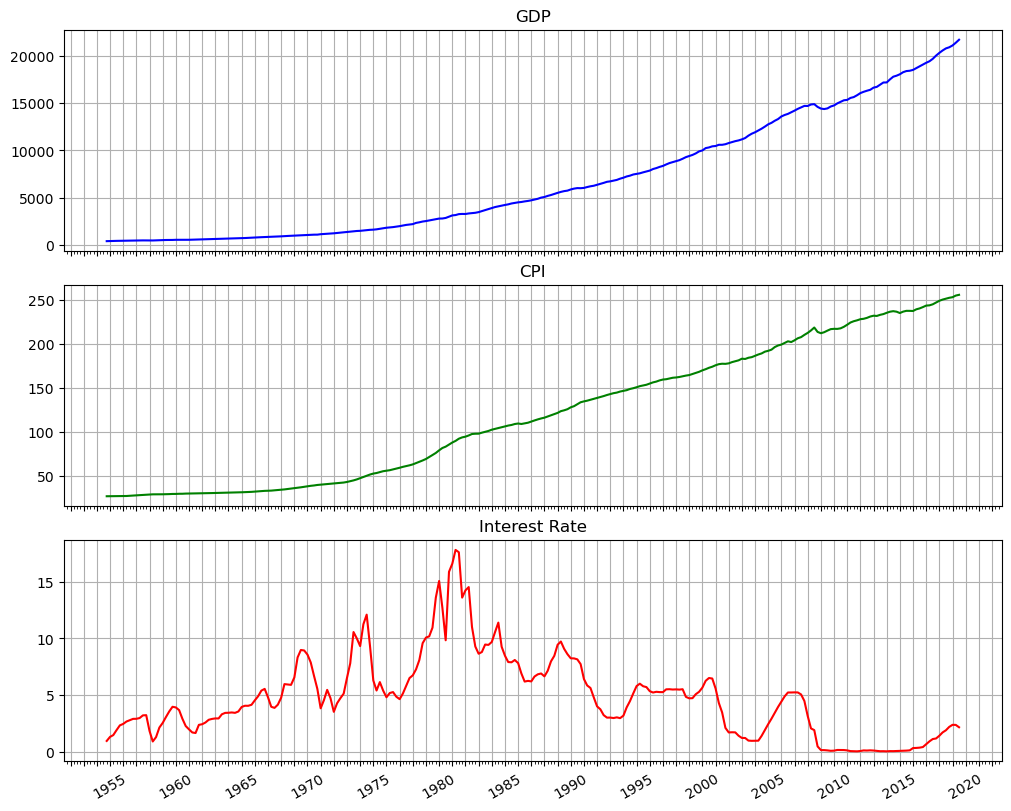

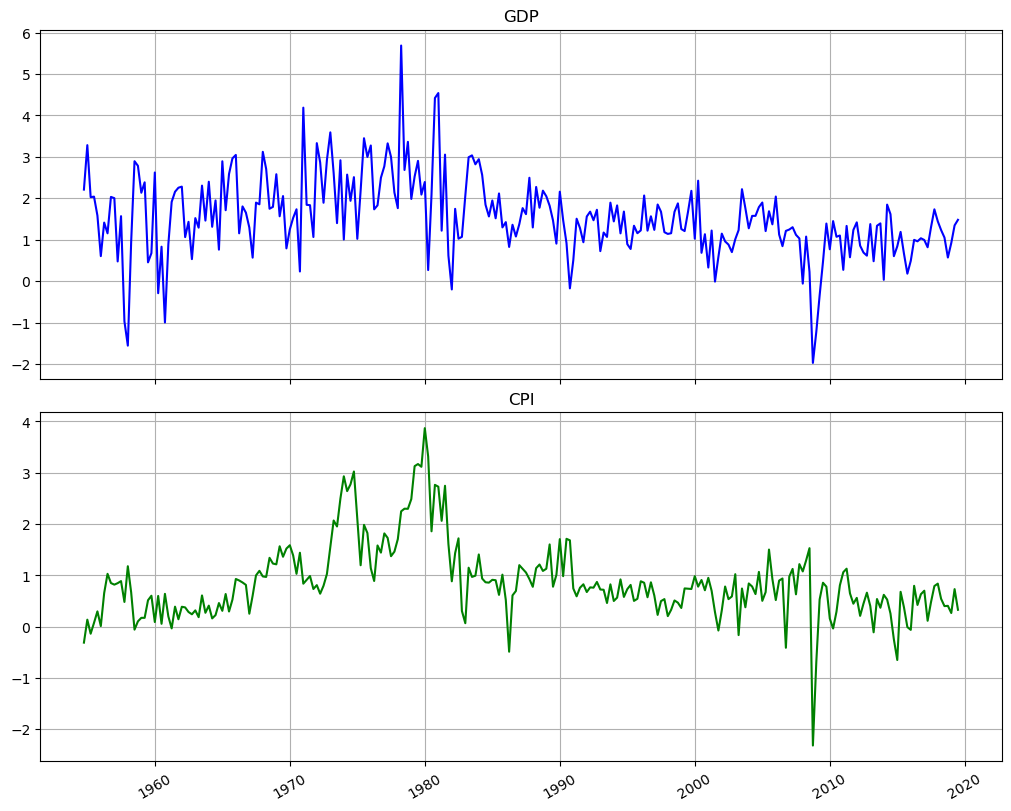

In [24]:
plot(data_out_covid)
plot_growth(data_out_covid)

In [12]:
max_lags=5
intercept = True
# Change variabes and data set yourself so desired setting
run_AR_models(data_out_covid, 'gdp', max_lags, intercept)

   lag variable       coef        se      t-value
0    1    const  22.033888  5.587027     3.943759
1    1    gdp_1   1.008910  0.000603  1674.100810
Log-likelihood: -371.5820
AIC: 		8.1615
   lag variable       coef        se    t-value
0    2    const  12.177169  5.160877   2.359515
1    2    gdp_1   1.458337  0.056718  25.712019
2    2    gdp_2  -0.453405  0.057218  -7.924232
Log-likelihood: -370.0537
AIC: 		7.9505
   lag variable       coef        se    t-value
0    3    const  10.788655  5.197710   2.075655
1    3    gdp_1   1.408844  0.062951  22.379928
2    3    gdp_2  -0.291064  0.107547  -2.706385
3    3    gdp_3  -0.113398  0.063716  -1.779743
Log-likelihood: -368.6304
AIC: 		7.9496
   lag variable      coef        se    t-value
0    4    const  9.951513  5.233486   1.901507
1    4    gdp_1  1.399457  0.063312  22.104130
2    4    gdp_2 -0.313233  0.108838  -2.877973
3    4    gdp_3 -0.000990  0.109281  -0.009056
4    4    gdp_4 -0.081204  0.064177  -1.265318
Log-likelihood: 

In [13]:
run_AR_models(data_out_covid, 'cpi', max_lags, intercept)

   lag variable      coef        se      t-value
0    1    const  0.513907  0.094894     5.415600
1    1    cpi_1  1.003193  0.000668  1502.012351
Log-likelihood: -367.2714
AIC: 		-0.4596
   lag variable      coef        se    t-value
0    2    const  0.309844  0.090918   3.407931
1    2    cpi_1  1.419099  0.057282  24.774084
2    2    cpi_2 -0.417314  0.057472  -7.261138
Log-likelihood: -365.7595
AIC: 		-0.6380
   lag variable      coef        se    t-value
0    3    const  0.308346  0.092759   3.324169
1    3    cpi_1  1.416828  0.063218  22.411859
2    3    cpi_2 -0.409621  0.106673  -3.839969
3    3    cpi_3 -0.005434  0.063419  -0.085679
Log-likelihood: -364.3424
AIC: 		-0.6264
   lag variable      coef        se    t-value
0    4    const  0.260213  0.092851   2.802493
1    4    cpi_1  1.416562  0.062283  22.743988
2    4    cpi_2 -0.486742  0.108339  -4.492785
3    4    cpi_3  0.255177  0.108667   2.348249
4    4    cpi_4 -0.183606  0.062637  -2.931248
Log-likelihood: -362.9086

In [14]:
run_AR_models(data_out_covid, 'ir', max_lags, intercept)

   lag variable      coef        se    t-value
0    1    const  0.141613  0.091315   1.550815
1    1     ir_1  0.970743  0.015131  64.156334
Log-likelihood: -367.3468
AIC: 		-0.3089
   lag variable      coef        se    t-value
0    2    const  0.178379  0.088658   2.012002
1    2     ir_1  1.226868  0.060756  20.193365
2    2     ir_2 -0.263783  0.060733  -4.343315
Log-likelihood: -365.8937
AIC: 		-0.3696
   lag variable      coef        se    t-value
0    3    const  0.149477  0.088271   1.693389
1    3     ir_1  1.270796  0.062253  20.413274
2    3     ir_2 -0.467438  0.097146  -4.811708
3    3     ir_3  0.165777  0.062186   2.665841
Log-likelihood: -364.4627
AIC: 		-0.3859
   lag variable      coef        se    t-value
0    4    const  0.175092  0.087516   2.000687
1    4     ir_1  1.300061  0.062250  20.884512
2    4     ir_2 -0.550274  0.100136  -5.495282
3    4     ir_3  0.390798  0.100124   3.903159
4    4     ir_4 -0.176820  0.062191  -2.843176
Log-likelihood: -363.0298
AIC: 